In [1]:
import h5py
import numpy 
import numpy as np
import random
from matplotlib import pyplot as plt
from keras.models import load_model
from keras import backend as K
from keras.models import Model
import tensorflow as tf
from keras.utils import to_categorical
import matplotlib
import time
from matplotlib.colors import LogNorm, Normalize

In [2]:
plt.rcParams["font.family"] = "serif"

In [3]:
# load jet images and remove pixel intensities lower than 1e-3
data = h5py.File('../input/jets-dataset/PYTHIA_JETS.hdf5', 'r')
JETS = numpy.array(data["image"][:])
JETS[JETS < 1e-3] = 0

# load jet labels (QCD or W boson)
data2 = h5py.File('../input/jets-dataset/PYTHIA_JETS.hdf5', 'r')
JETS_label = numpy.array(data2["signal"][:])

In [4]:
# load decoder model
# we don't need the encoder or the whole VAE model for analysis
decoder = load_model('../input/model4paper/Model4paper_decoder.h5')

In [5]:
# define the number of jets to generate 
# to save time, we reduce the number of jets generated to 10000 (the paper uses 300000)
n = 10000
jets = JETS[0:n]
JETS_label = JETS_label[0:n].reshape(n,)

latent_size = 12
c_space = 1

# generates fake labels and random latent noise
latent_noise = np.random.normal(0, 1, (n, latent_size))
fake_labels = np.random.randint(0, 2, n).reshape(n,1)
fake_label = to_categorical(fake_labels, num_classes = 2)
combined = np.concatenate([latent_noise, fake_label], axis = 1)

In [6]:
# generate data given fake labels and random latent noise
# we include time to graph a time chart later
start_time = time.time()
vae_images = decoder.predict(combined) * 100
vae_time = time.time() - start_time

In [7]:
vae_images = vae_images.reshape(n,25,25)
vae_images[vae_images < 1e-3] = 0 

In [8]:
# separates QCD and W boson jet images into separate variables for VAE and Pythia jet images

QCD_filter = np.where((JETS_label == 0 ))
W_filter = np.where((JETS_label == 1))
QCD_JETS, W_JETS = JETS[QCD_filter], JETS[W_filter]

fake_labels = fake_labels.reshape(n,)
QCD_filter2 = np.where((fake_labels == 0 ))
W_filter2 = np.where((fake_labels == 1))
VAE_QCD_JETS, VAE_W_JETS = vae_images[QCD_filter2], vae_images[W_filter2]

In [9]:
# used to plot jet images
# code is inspired from https://github.com/hep-lbdl/adversarial-jets/blob/master/analysis/plots.ipynb

def plot_jet_image(content, title=''):
    fig, ax = plt.subplots(figsize=(7, 6))
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.4)
        
    im = ax.imshow(content, interpolation='nearest', norm=LogNorm(vmin=1e-6, vmax=300), extent=[-1.25, 1.25, -1.25, 1.25], cmap = 'plasma')
    cbar = plt.colorbar(im, fraction=0.05, pad=0.02)
    cbar.set_label(r'Pixel $p_T$ [GeV]', y=0.85)
    cbar.ax.tick_params(labelsize=13)
    cbar.outline.set_linewidth(2.4)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax.tick_params(axis="y",direction="in", length=11, width=2.5)
    ax.tick_params(axis="x",direction="in", length=11, width=2.5)
    
    plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$', fontsize = '13')
    plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$', fontsize = '13')
    plt.title(title, pad = 15, fontsize = '17')
    
    fig.savefig(title + '.pdf', bbox_inches='tight')
    
def plot_diff_jet_image(content, color, extr, title='', save_title = ''):

    fig, ax = plt.subplots(figsize=(7, 6))
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.4)
        
    im = ax.imshow(content, interpolation='nearest', norm=Normalize(vmin=-extr, vmax=+extr), extent=[-1.25, 1.25, -1.25, 1.25], cmap=color)
    cbar = plt.colorbar(im, fraction=0.05, pad=0.02)
    cbar.ax.tick_params(labelsize=13)
    cbar.outline.set_linewidth(2.4)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax.tick_params(axis="y",direction="in", length=11, width=2.5)
    ax.tick_params(axis="x",direction="in", length=11, width=2.5)
    
    plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$', fontsize = '13')
    plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$', fontsize = '13')
    plt.title(title, wrap=True, pad = 15, fontsize = '17')
    
    #removes downloading error (\n in the title causes downloading problems)
    fig.savefig((save_title + '.pdf'), bbox_inches='tight')

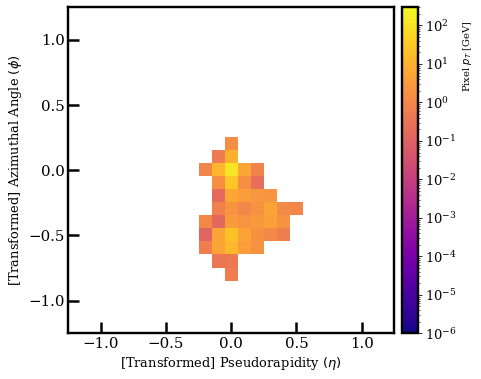

In [10]:
# generate a random VAE jet image
x = random.randrange(n)
plot_jet_image(vae_images[x])

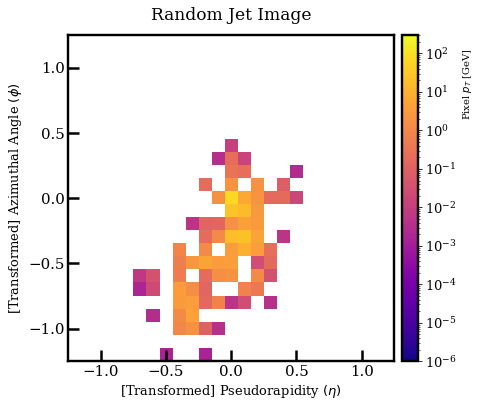

In [11]:
# generate a random Pythia jet image
plot_jet_image(JETS[x], title = "Random Jet Image")

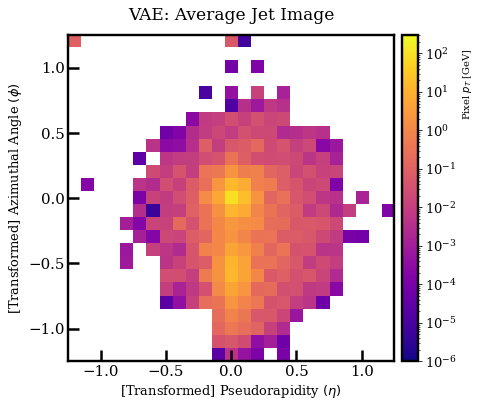

In [12]:
# shows the average VAE jet image
plot_jet_image(vae_images.mean(axis=0), title='VAE: Average Jet Image')

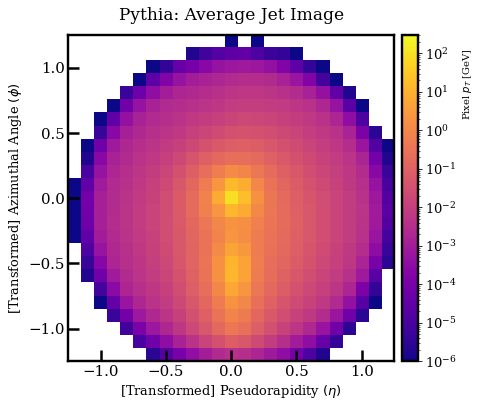

In [13]:
# shows the average Pythia jet image
plot_jet_image(JETS.mean(axis=0), title='Pythia: Average Jet Image')

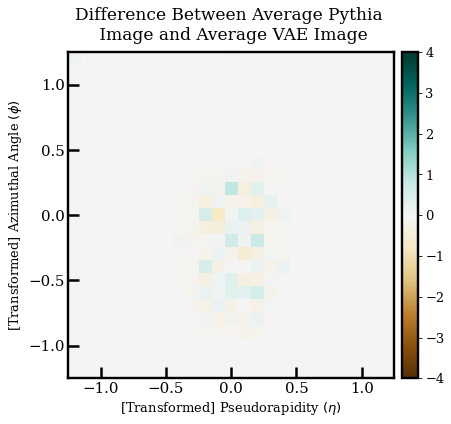

In [14]:
# shows the difference between average VAE and Pythia jet image
plot_diff_jet_image(vae_images.mean(axis=0)- JETS.mean(axis=0) ,"BrBG", 4, title='Difference Between Average Pythia \n Image and Average VAE Image', 
                    save_title = 'Difference Between Average Pythia Image and Average VAE Image')

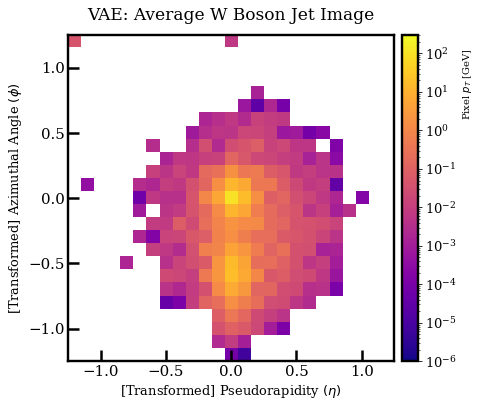

In [15]:
# shows the average VAE W boson jet image
plot_jet_image(VAE_W_JETS.mean(axis=0), title='VAE: Average W Boson Jet Image')

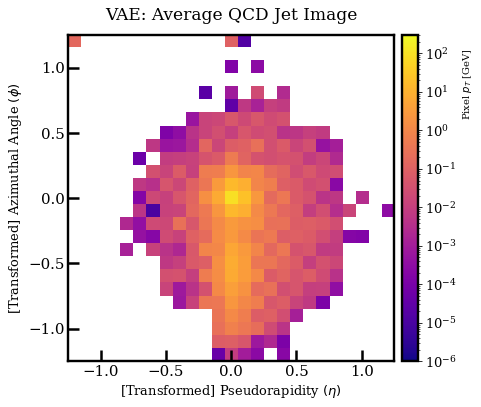

In [16]:
# shows the average VAE QCD jet image
plot_jet_image(VAE_QCD_JETS.mean(axis=0), title='VAE: Average QCD Jet Image')

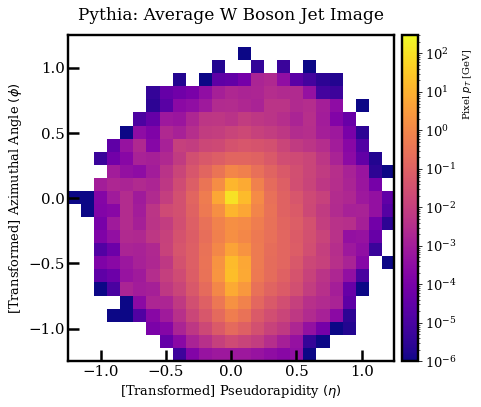

In [17]:
# shows the average Pythia W boson jet image
plot_jet_image(W_JETS.mean(axis=0), title='Pythia: Average W Boson Jet Image')

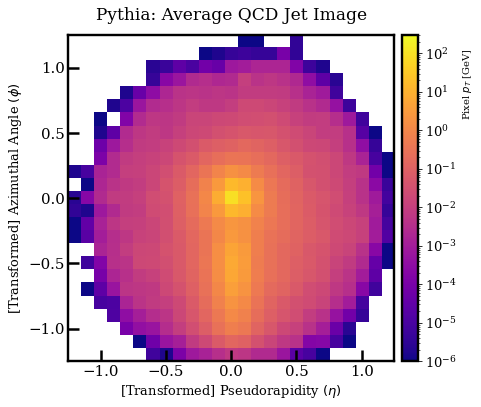

In [18]:
# shows the average Pythia QCD jet image
plot_jet_image(QCD_JETS.mean(axis=0), title='Pythia: Average QCD Jet Image')

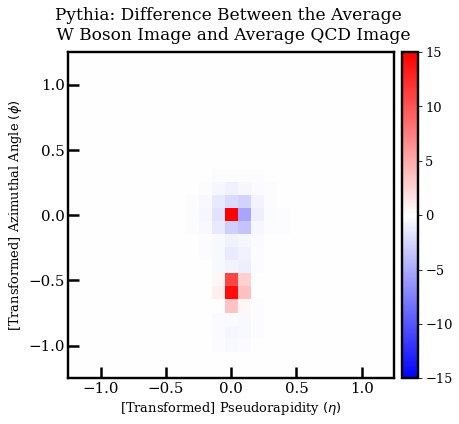

In [19]:
# shows difference between Pythia W boson and Pythia QCD
plot_diff_jet_image(W_JETS.mean(axis=0) - QCD_JETS.mean(axis=0) ,"bwr", 15, title='Pythia: Difference Between the Average \n W Boson Image and Average QCD Image',
                   save_title='Pythia: Difference Between the Average W Boson Image and Average QCD Image')

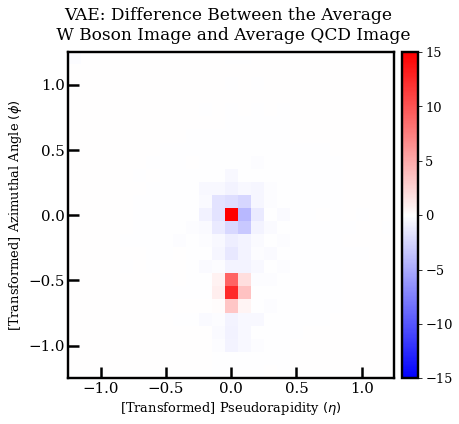

In [20]:
# shows difference between VAE W boson and VAE QCD
plot_diff_jet_image(VAE_W_JETS.mean(axis=0) - VAE_QCD_JETS.mean(axis=0) ,"bwr", extr = 15, title='VAE: Difference Between the Average \n W Boson Image and Average QCD Image',
                   save_title='VAE: Difference Between the Average W Boson Image and Average QCD Image')

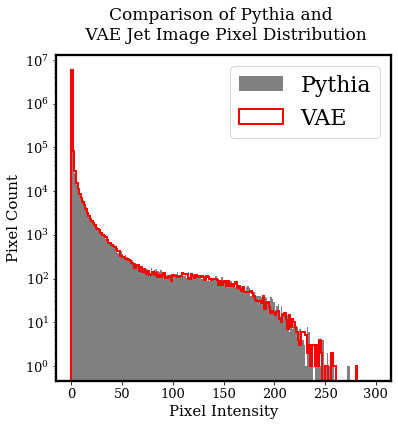

In [21]:
# graph the pixel distribution of Pythia and VAE jet images

fig, ax = plt.subplots(figsize=(6, 6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.3)

plt.hist(JETS[0:n].ravel(), bins=np.linspace(0, 300,200), histtype='stepfilled', label='Pythia', color='gray', linewidth = 2)
plt.hist(vae_images.ravel(), bins=np.linspace(0, 300,200), histtype='step', label='VAE', color='red', linewidth = 2)

plt.xlabel('Pixel Intensity', fontsize = 15)
plt.ylabel('Pixel Count', fontsize = 15)
plt.yscale('log')

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Comparison of Pythia and \n VAE Jet Image Pixel Distribution', fontsize = 17, pad = 15)
plt.legend(loc='upper right', fontsize = 22)

fig.savefig('Comparison of Pythia and VAE Jet Image Pixel Distribution.pdf', bbox_inches='tight')

In [22]:
# this code is borrowed from https://github.com/hep-lbdl/adversarial-jets/blob/master/analysis/plots.ipynb
# calculates mass, pT, and N-subjettiness

grid = 0.5 * (np.linspace(-1.25, 1.25, 26)[:-1] + np.linspace(-1.25, 1.25, 26)[1:])
eta = np.tile(grid, (25, 1))
phi = np.tile(grid[::-1].reshape(-1, 1), (1, 25))

def discrete_mass(jet_image):
   
    Px = np.sum(jet_image * np.cos(phi), axis=(1,2))
    Py = np.sum(jet_image * np.sin(phi), axis=(1,2))

    Pz = np.sum(jet_image * np.sinh(eta), axis=(1,2))
    E = np.sum(jet_image * np.cosh(eta), axis=(1,2))

    PT2 = np.square(Px) + np.square(Py)
    M2 = np.square(E) - (PT2 + np.square(Pz))
    M = np.sqrt(M2)
    return M

def discrete_pt(jet_image):
   
    Px = np.sum(jet_image * np.cos(phi), axis=(1,2))
    Py = np.sum(jet_image * np.sin(phi), axis=(1,2))
    return np.sqrt(np.square(Px) + np.square(Py))

def dphi(phi1, phi2): 
 
    import math
    return math.acos(math.cos(abs(phi1 - phi2)))

def _tau1(jet_image):

    # find coordinate of most energetic pixel, then use formula to compute tau1
    tau1_axis_eta = eta.ravel()[np.argmax(jet_image)]
    tau1_axis_phi = phi.ravel()[np.argmax(jet_image)]
    tau1 = np.sum(jet_image * 
            np.sqrt(np.square(tau1_axis_eta - eta) + np.square([dphi(tau1_axis_phi, p) for p in phi.ravel()]).reshape(25, 25))
                 ) 
    return tau1 / np.sum(jet_image) # normalize by the total intensity


def _tau2(jet_image):

    proto = np.array(list(zip(jet_image[jet_image != 0],
                         eta[jet_image != 0],
                         phi[jet_image != 0])))

    while len(proto) > 2:
        candidates = [
            (
                (i, j),
                (min(pt1, pt2) ** 2) * ((eta1 - eta2) ** 2 + (phi1 - phi2) ** 2)
            )
            for i, (pt1, eta1, phi1) in enumerate(proto)
            for j, (pt2, eta2, phi2) in enumerate(proto)
            if j > i
        ]

        index, value = zip(*candidates)
        pix1, pix2 = index[np.argmin(value)]
        if pix1 > pix2:
            # swap
            pix1, pix2 = pix2, pix1

        (pt1, eta1, phi1) = proto[pix1]
        (pt2, eta2, phi2) = proto[pix2]

        e1 = pt1 / np.cosh(eta1)
        e2 = pt2 / np.cosh(eta2)
        choice = e1 > e2

        eta_add = (eta1 if choice else eta2)
        phi_add = (phi1 if choice else phi2)
        pt_add = (e1 + e2) * np.cosh(eta_add)

        proto[pix1] = (pt_add, eta_add, phi_add)

        proto = np.delete(proto, pix2, axis=0).tolist()

    (_, eta1, phi1), (_, eta2, phi2) = proto
    np.sqrt(np.square(eta - eta1) + np.square(phi - phi1))

    grid = np.array([
        np.sqrt(np.square(eta - eta1) + np.square(phi - phi1)),
        np.sqrt(np.square(eta - eta2) + np.square(phi - phi2))
    ]).min(axis=0)

    return np.sum(jet_image * grid) / np.sum(jet_image) # normalize by the total intensity

def tau21(jet_image):

    tau1 = _tau1(jet_image)
    if tau1 <= 0:
        return 0
    else:
        tau2 = _tau2(jet_image)
        return tau2 / tau1

In [23]:
# loop used to calculate N-subjettiness

def calculate_tau21(content):
    
    tau = list()

    for jet in content:
        tau.append(tau21(jet))

    tau21_re = np.array(tau)
    return tau21_re

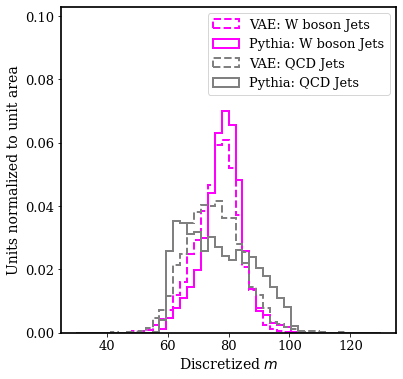

In [24]:
# calculates mass distribution
fig, ax = plt.subplots(figsize=(6, 6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.7)
    
bins = np.linspace(30, 130, 45)
plt.hist(discrete_mass(VAE_W_JETS).ravel(), bins=bins, histtype='step', label=r"VAE: W boson Jets", density=True, color='magenta', linestyle='dashed', linewidth = 2)
plt.hist(discrete_mass(W_JETS).ravel(), bins=bins, histtype='step', label=r"Pythia: W boson Jets", density=True, color='magenta', linewidth = 2)
plt.hist(discrete_mass(VAE_QCD_JETS).ravel(), bins=bins, histtype='step', label=r'VAE: QCD Jets', density=True, color='gray', linestyle='dashed', linewidth = 2)
plt.hist(discrete_mass(QCD_JETS).ravel(), bins=bins, histtype='step', label=r'Pythia: QCD Jets', density=True, color='gray', linewidth = 2)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
    
plt.xlabel(r'Discretized $m$', fontsize = 14, fontname= 'serif')
plt.ylabel(r'Units normalized to unit area', fontsize = 14, fontname= 'serif')

plt.legend(fontsize = 13)
plt.ylim(0, 0.103)

fig.savefig('Mass Distribution.pdf', bbox_inches='tight')

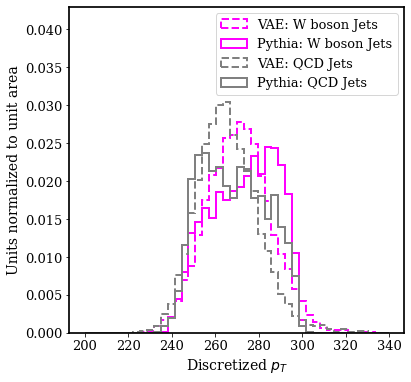

In [25]:
# calculates pT distribution
fig, ax = plt.subplots(figsize=(6, 6))
bins = np.linspace(200, 340, 45)
plt.hist(discrete_pt(VAE_W_JETS), bins=bins, histtype='step', label=r"VAE: W boson Jets", density=True, color='magenta', linestyle='dashed', linewidth = 2)
plt.hist(discrete_pt(W_JETS), bins=bins, histtype='step', label=r"Pythia: W boson Jets", density=True, color='magenta', linewidth = 2)

plt.hist(discrete_pt(VAE_QCD_JETS), bins=bins, histtype='step', label=r'VAE: QCD Jets', density=True, color='gray', linestyle='dashed', linewidth = 2)
plt.hist(discrete_pt(QCD_JETS), bins=bins, histtype='step', label=r'Pythia: QCD Jets', density=True, color='gray', linewidth = 2)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.7)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel(r'Discretized $p_T$', fontsize = 14, fontname= 'serif')
plt.ylabel(r'Units normalized to unit area', fontsize = 14, fontname= 'serif')
plt.legend(fontsize = 13)
plt.ylim(0, 0.043)

fig.savefig('pT Distribution.pdf', bbox_inches='tight')

In [26]:
# separately generate N-subjettiness (takes a long time)
# we only use 1000 jets to save time but the paper calculates 10,000 jet images
t_n = 1000
VAE_W_tau = calculate_tau21(VAE_W_JETS[0:t_n])
pythia_W_tau = calculate_tau21(W_JETS[0:t_n])
VAE_QCD_tau = calculate_tau21(VAE_QCD_JETS[0:t_n])
pythia_QCD_tau = calculate_tau21(QCD_JETS[0:t_n])

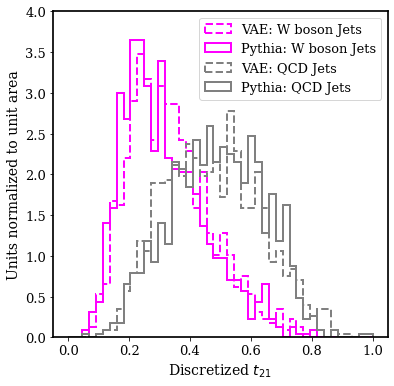

In [27]:
# graph N-subjettiness distribution

fig, ax = plt.subplots(figsize=(6, 6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.7)
    
bins = np.linspace(0, 1, 45)
plt.hist(VAE_W_tau.ravel(), bins=bins, histtype='step', label=r"VAE: W boson Jets", density=True, color='magenta', linestyle='dashed', linewidth = 2)
plt.hist(pythia_W_tau.ravel(), bins=bins, histtype='step', label=r"Pythia: W boson Jets", density=True, color='magenta', linewidth = 2)

plt.hist(VAE_QCD_tau.ravel(), bins=bins, histtype='step', label=r"VAE: QCD Jets", density=True, color='gray', linestyle='dashed', linewidth = 2)
plt.hist(pythia_QCD_tau.ravel(), bins=bins, histtype='step', label=r'Pythia: QCD Jets', density=True, color='gray', linewidth = 2)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel(r'Discretized $t_{21}$', fontsize = 14, fontname= 'serif')
plt.ylabel(r'Units normalized to unit area', fontsize = 14, fontname= 'serif')
plt.legend(fontsize = 13)
plt.ylim(0, 4.0)

fig.savefig('tau21 Distribution.pdf', bbox_inches='tight')

In [28]:
# these two functions generate linear interpolations for each latent space value

def generate(n,c):
    image_list = []
    for i in range(0, columns):

        array = np.zeros((1, latent_size))
        array[0,n] = (i*variation) - (columns / 2)
        
        label = to_categorical(np.array(c).reshape(1,1), num_classes = 2)
        
        combined = np.concatenate([array, label], axis = 1)
        image = decoder.predict(combined)

        image_list.append(image)
    image_list = np.array(image_list)
    image_list = image_list.reshape(columns,25,25)
    return image_list

def interpolerate(columns, variation, c):
       
    fig, ax = plt.subplots(figsize=(16, 10))
    for j in range(0, latent_size):
        for i in range(1, columns):

            sg = generate(j,c)
            ax = plt.subplot(latent_size, columns, i + (columns*j))
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(1.7)
                
            plt.imshow(sg[i].reshape(25, 25)*100, interpolation='nearest', norm=LogNorm(vmin=1e-3, vmax=300), cmap = 'plasma')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
    plt.show()
    
    if c == 0:
        fig.savefig('Latent Space Linear Interpolation QCD.pdf', bbox_inches='tight')
    else:
        fig.savefig('Latent Space Linear Interpolation W boson.pdf', bbox_inches='tight')

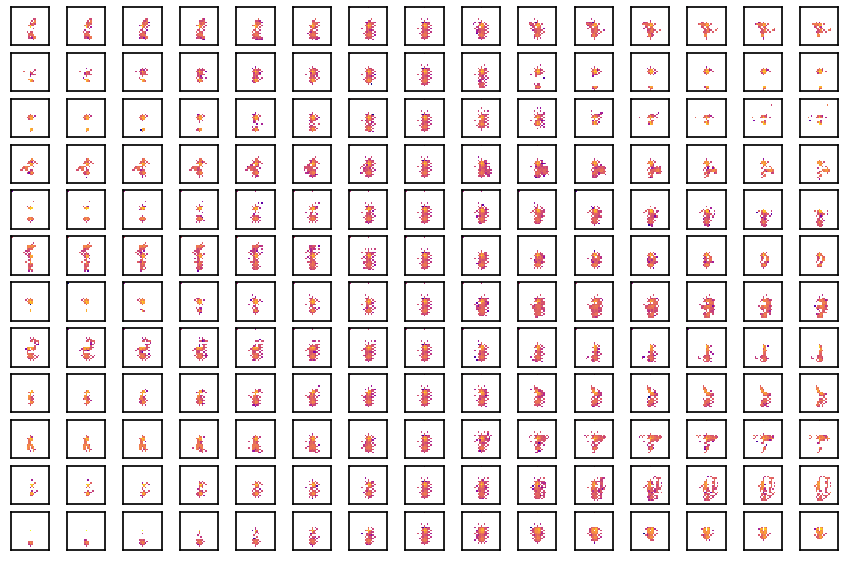

In [29]:
# generates a linear interpolation of QCD jet images
columns = 16
variation = 1
interpolerate(columns, variation, 0)

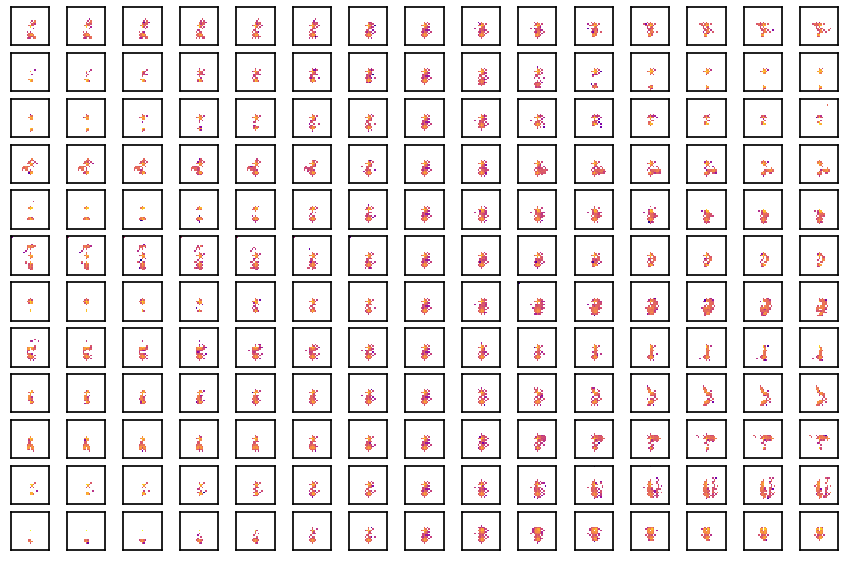

In [30]:
# generates a linear interpolation of W boson jet images
interpolerate(columns, variation, 1)

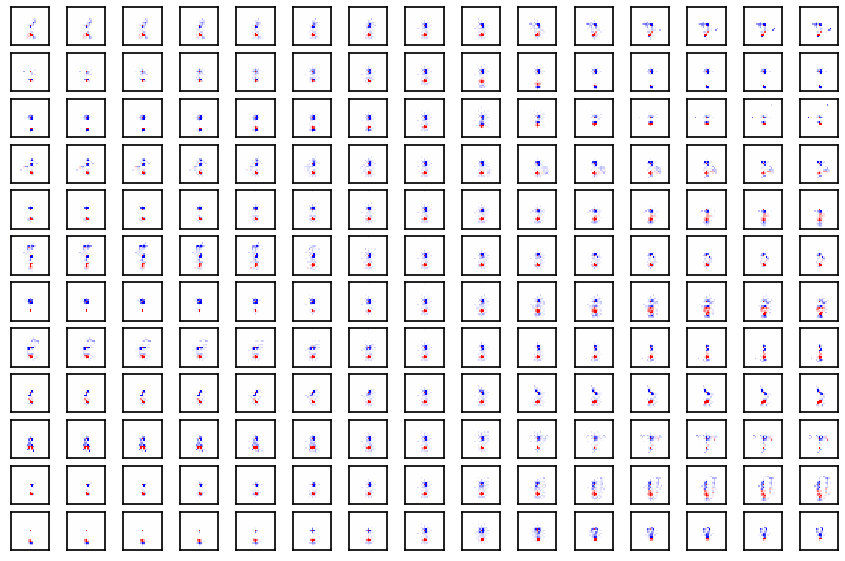

In [31]:
# generates linear interpolation of PCC of W boson and QCD jet images
fig, ax = plt.subplots(figsize=(16, 10))
for j in range(0, latent_size):
    for i in range(1, columns):

        w = generate(j,1) *100
        w[w<1e-3] = 0
        
        q = generate(j,0) *100
        q[q<1e-3] = 0
        
        ab = w-q
        
        ax = plt.subplot(latent_size, columns, i + (columns*j))
        plt.imshow(ab[i].reshape(25, 25), interpolation ='nearest', cmap = "bwr", norm=Normalize(vmin=-5, vmax=+5))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.7)
plt.show()
fig.savefig('Latent Space Linear Interpolation PCC.pdf', bbox_inches='tight')

In [32]:
# functions that generates jet images for various regions in the N(0,1) space

def generate_images(mu, sigma, n, z):
    latent_noise = np.random.normal(mu, sigma, (n, z))
    fake_labels = np.random.randint(0, 2, n).reshape(n,1)
    fake_label = to_categorical(fake_labels, num_classes =2)
    
    combined = np.concatenate([latent_noise, fake_label], axis = 1)
    vae_images = decoder.predict(combined) * 100

    vae_images = vae_images.reshape(n,25,25)
    vae_images[vae_images < 1e-3] = 0 
    images, QCD, W = vae_images, vae_images[fake_labels.reshape(n,) == 0], vae_images[fake_labels.reshape(n,) == 1]
    
    return images, QCD, W

def looped_sigma(intervals, n, z):
    jets = [] 
    QCD = []
    W = [] 
    for i in range(0, intervals):
        
        mu = -1 + (2 / intervals) * (i+0.5)
        sigma = 1 / intervals
        
        j, q, w = generate_images(mu, sigma, n, z)
        
        jets.append(j)
        QCD.append(q)
        W.append(w)
        
    return jets, QCD, W

In [33]:
# generates jet images for various regions in the N(0,1) space
# the intervals can be increased or decrease to get a more diverse amount of curves
# to save time, we reduce the number of jets to 6000 (the paper uses 50,000)
intervals = 8
count = 6000
interval_jet, interval_QCD, interval_W = looped_sigma(intervals, count, latent_size)

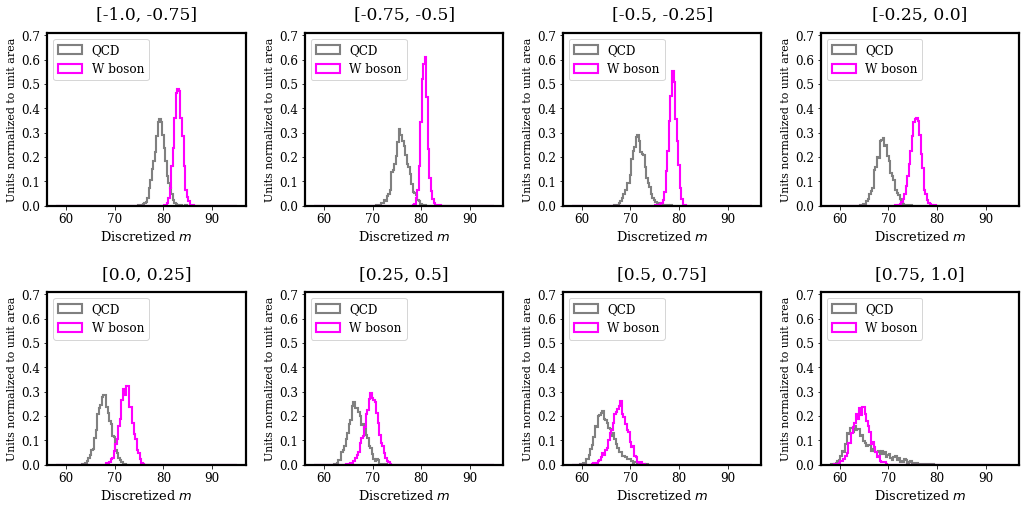

In [34]:
# plots mass for various regions in the N(0,1) space

fig, ax = plt.subplots(figsize=(13.5, 6))
bins = np.linspace(58, 95, 120)

for i in range(0, intervals):
    
    axs = plt.subplot((intervals/4), 4, i+1)
    
    for axis in ['top','bottom','left','right']:
        axs.spines[axis].set_linewidth(2.2) 
        
    plt.hist(discrete_mass(interval_QCD[i]).ravel(), bins=bins, histtype='step', density=True, color = 'gray', label = "QCD", linewidth = 2.1)
    plt.hist(discrete_mass(interval_W[i]).ravel(), bins=bins, histtype='step', density=True, color = 'magenta', label = "W boson" , linewidth = 2.1)
    
    a = -1 + (2 / intervals) * (i+0.5)
    b = 1 / intervals
    
    plt.title(str([a-(b), a+(b)]), fontsize = 17, y = 1.04, fontname= 'serif')
    plt.legend(loc="upper left", fontsize = 12)
    plt.xlabel('Discretized $m$', fontsize=13)
    plt.ylabel('Units normalized to unit area', fontsize=11)
        
    plt.xticks(fontsize=12, fontname= 'serif')
    plt.yticks(fontsize=12, fontname= 'serif')
    
    plt.ylim(0, 0.71)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.5)

fig.savefig('N(0,1) Mass Distributions.pdf', bbox_inches='tight')

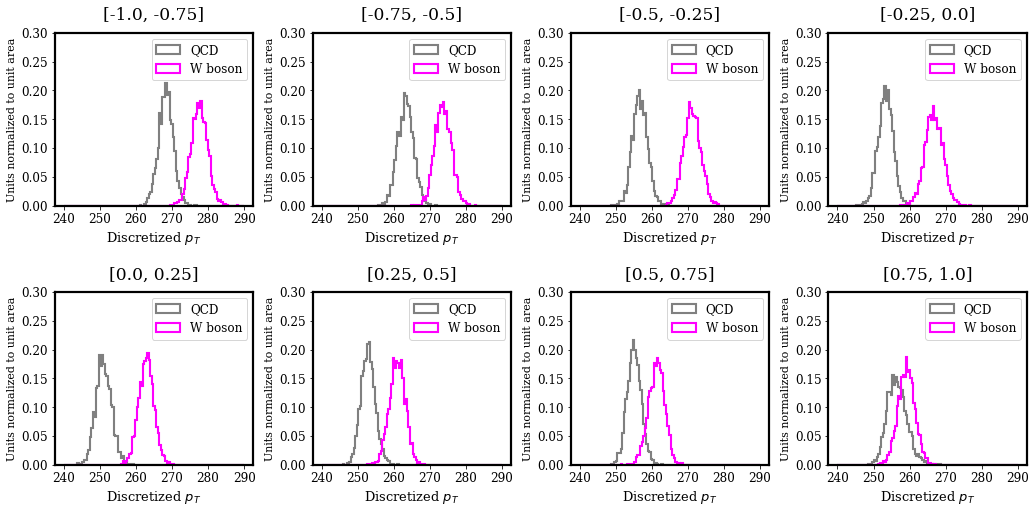

In [35]:
# plots pT for various regions in the N(0,1) space

fig, ax = plt.subplots(figsize=(13.5, 6))
bins = np.linspace(240, 290, 120)

for i in range(0, intervals):
    axs = plt.subplot((intervals/4), 4, i+1)
    
    for axis in ['top','bottom','left','right']:
        axs.spines[axis].set_linewidth(2.2) 
        
    plt.hist(discrete_pt(interval_QCD[i]).ravel(), bins=bins, histtype='step', density=True, color = 'gray', label = "QCD" , linewidth = 2.1)
    plt.hist(discrete_pt(interval_W[i]).ravel(), bins=bins, histtype='step', density=True, color = 'magenta', label = "W boson", linewidth = 2.1)
    
    a = -1 + (2 / intervals) * (i+0.5)
    b = 1 / intervals
    
    plt.title( str([a-(b), a+(b)]), fontsize = 17, y = 1.04)
    plt.xlabel('Discretized $p_T$', fontsize = 13)
    plt.ylabel('Units normalized to unit area', fontsize = 11)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
        
    plt.legend(loc="upper right", fontsize = 12)
    plt.ylim(0, 0.3)
    
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.5)
fig.savefig('N(0,1) pT Distributions.pdf', bbox_inches='tight')

In [36]:
# define a separate amount of jet images for N-subjettiness because it is time consuming
# we use 700 jet images for this notebook but the paper uses 10000
tau_count = 700
tau_interval_jet, tau_interval_QCD, tau_interval_W = looped_sigma(intervals, tau_count, latent_size)

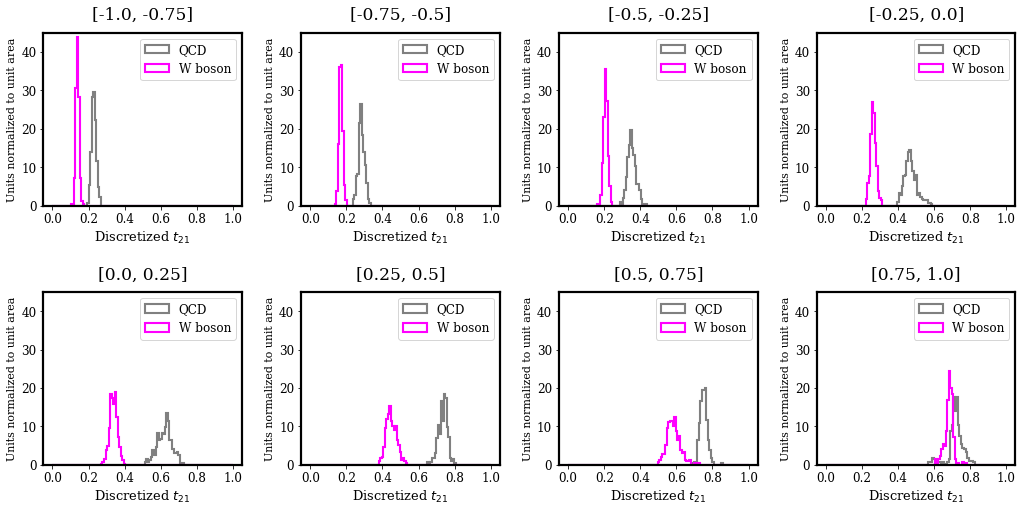

In [37]:
# plot t21 for various regions in the N(0,1) space

fig, ax = plt.subplots(figsize=(13.5, 6))
bins = np.linspace(0, 1, 120)

for i in range(0, intervals):
    axs = plt.subplot((intervals/4), 4, i+1)
    
    for axis in ['top','bottom','left','right']:
        axs.spines[axis].set_linewidth(2.2) 
        
    plt.hist(calculate_tau21(tau_interval_QCD[i]).ravel(), bins=bins, histtype='step', density=True, color = 'gray', label = "QCD" , linewidth = 2.1)
    plt.hist(calculate_tau21(tau_interval_W[i]).ravel(), bins=bins, histtype='step', density=True, color = 'magenta', label = "W boson", linewidth = 2.1)
    
    a = -1 + (2 / intervals) * (i+0.5)
    b = 1 / intervals
    
    plt.title( str([a-(b), a+(b)]), fontsize = 17, y = 1.04, fontname= 'serif')
    plt.xlabel('Discretized $t_{21}$', fontsize = 13)
    plt.ylabel('Units normalized to unit area', fontsize = 11)
    plt.xticks(fontsize=12, fontname= 'serif')
    plt.yticks(fontsize=12, fontname= 'serif')
    
    plt.legend(loc="upper right", fontsize = 12)
    plt.ylim(0, 45)
    
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.5)
fig.savefig('N(0,1) t21 Distributions.pdf', bbox_inches='tight')

In [38]:
# generates the average jet image for a list that contains a group of jet images
def plot_mean(content):
    images = [] 
    for i in content:
        a = i.mean(axis=0)
        images.append(a)
    images = np.array(images)
    return images

mean_jets = plot_mean(interval_jet)
mean_QCD = plot_mean(interval_QCD)
mean_W = plot_mean(interval_W)
pcc = mean_W - mean_QCD

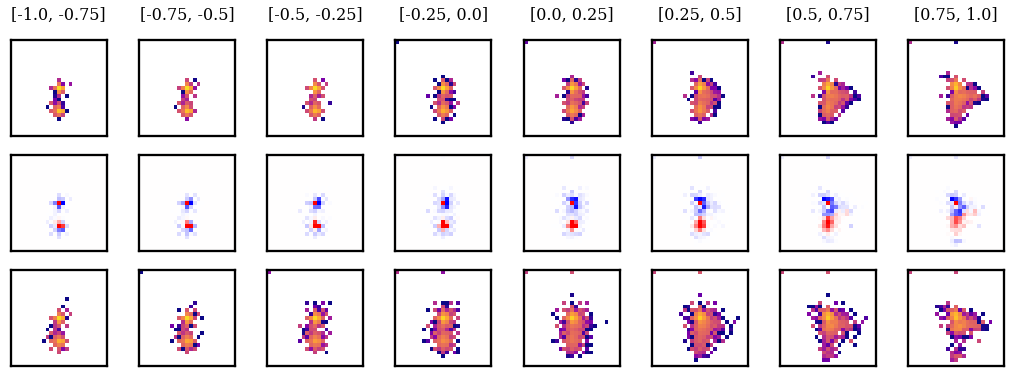

In [39]:
# plot the average W boson and QCD jet images in various regions of the N(0,1) space with a PCC of both images
shape_1 = mean_QCD.shape[0]

fig, ax = plt.subplots(figsize=(18, 6))

for i in range(0, shape_1):   
    ax = plt.subplot(3, shape_1, i+1)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.3)
    plt.imshow(mean_W[i].reshape(25, 25), interpolation='nearest', norm=LogNorm(vmin=1e-3, vmax=300), cmap = 'plasma')
    
    a = -1 + (2 / intervals)* (i+0.5)
    b = 2 / intervals
    ax.set_title(str([a-(b/2), a+(b/2)]), y = 1.15, fontsize = 16)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, shape_1, i+1 + shape_1)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.3) 
    plt.imshow(pcc[i].reshape(25, 25), interpolation ='nearest', cmap = "bwr", norm=Normalize(vmin=-5, vmax=+5))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, shape_1, i+1 + 2*shape_1)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.3)   
    plt.imshow(mean_QCD[i].reshape(25, 25), interpolation='nearest', norm=LogNorm(vmin=1e-3, vmax=300), cmap = 'plasma')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
fig.savefig("N(0,1) Average Jet Images with PCC.pdf", bbox_inches='tight')

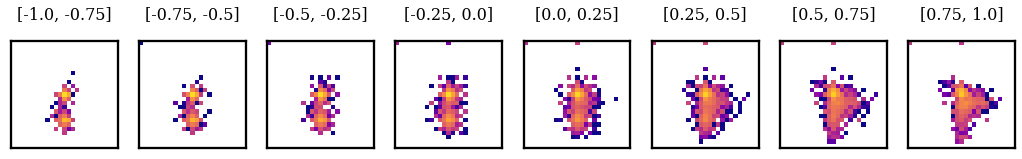

In [40]:
# not used in paper
fig, ax = plt.subplots(figsize=(18, 4))
for i in range(0, shape_1):
    ax = plt.subplot(1, shape_1, i+1)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.3) 
    plt.imshow(mean_jets[i].reshape(25, 25), interpolation='nearest', norm=LogNorm(vmin=1e-3, vmax=300), cmap = 'plasma')
    
    a = -1 + (2 / intervals)* (i+0.5)
    b = 2 / intervals
    ax.set_title(str([a-(b/2), a+(b/2)]), y = 1.15, fontsize = 16)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.savefig('N(0,1) Average Jet Images.pdf', bbox_inches='tight')

In [41]:
# a loop that generates jet images for each latent space value
lat_QCD = [] 
lat_W = [] 
for i in range(latent_size):
    random_latents = np.random.normal(0, 1, (count, 1))
    latent_0 = np.zeros((count, latent_size))
    
    y_offset = i
    latent_0[:random_latents.shape[0],y_offset:random_latents.shape[1]+y_offset] = random_latents
    
    ones = np.ones((count)).reshape(count,1)
    zeros = np.zeros((count)).reshape(count,1)
    
    ones = to_categorical(ones, num_classes = 2)
    zeros = to_categorical(zeros, num_classes = 2)
    
    comb1 = np.concatenate([latent_0, ones], axis = 1)
    comb2 = np.concatenate([latent_0, zeros], axis = 1)
    
    comb1_predicted = decoder.predict(comb1).reshape(count, 25,25) * 100
    comb2_predicted = decoder.predict(comb2).reshape(count, 25,25) * 100
    
    lat_W.append(comb1_predicted)
    lat_QCD.append(comb2_predicted)

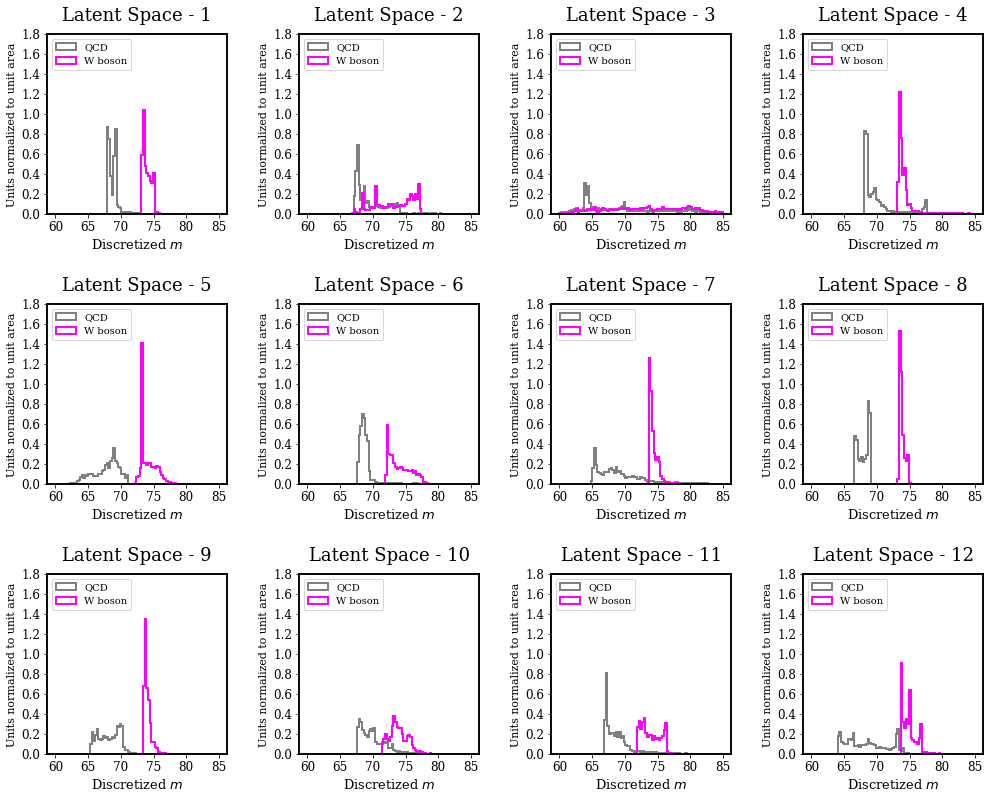

In [42]:
# calculates mass for jet images generated from each latent space value

fig, ax = plt.subplots(figsize=(13, 10))
bins = np.linspace(60, 85, 100)
for i in range(latent_size):
    axs = plt.subplot(3, 4, i+1)
    for axis in ['top','bottom','left','right']:
        axs.spines[axis].set_linewidth(1.9) 
        
    plt.hist(discrete_mass(lat_QCD[i]).ravel(), bins=bins, histtype='step', density=True, color = 'gray', label = "QCD", linewidth = 2)
    plt.hist(discrete_mass(lat_W[i]).ravel(), bins=bins, histtype='step', density=True, color = 'magenta', label = "W boson" , linewidth = 2)

    plt.title('Latent Space - ' + str(i+1), fontsize = 18, y = 1.04)
    plt.legend(loc="upper left", fontsize = 10)
    plt.xlabel('Discretized $m$', fontsize = 13)
    plt.ylabel('Units normalized to unit area', fontsize = 11)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.ylim(0, 1.8)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.4, hspace=0.5)
fig.savefig("Latent Space Mass Distributions.pdf", bbox_inches='tight')

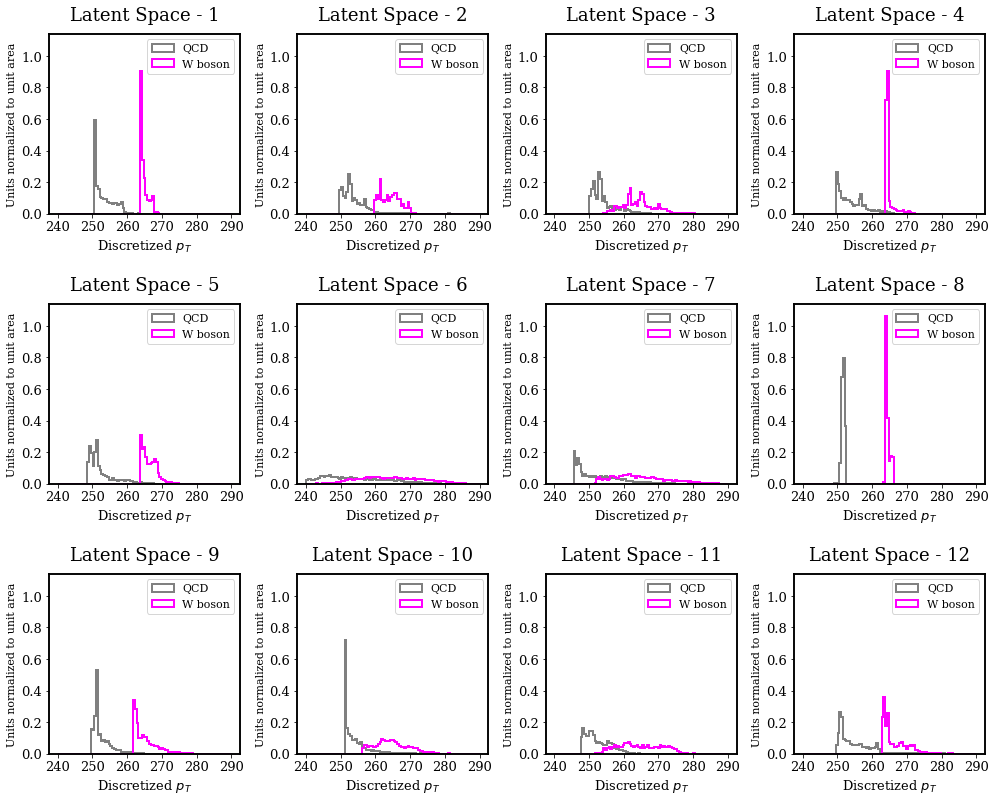

In [43]:
# calculates pT for jet images generated from each latent space value

fig, ax = plt.subplots(figsize=(13, 10))
bins = np.linspace(240,290, 100)
for i in range(latent_size):
    axs = plt.subplot(3, 4, i+1)
    for axis in ['top','bottom','left','right']:
        axs.spines[axis].set_linewidth(1.9) 
    plt.hist(discrete_pt(lat_QCD[i]).ravel(), bins=bins, histtype='step', density=True, color = 'gray', label = "QCD" , linewidth = 2)
    plt.hist(discrete_pt(lat_W[i]).ravel(), bins=bins, histtype='step', density=True, color = 'magenta', label = "W boson", linewidth = 2)

    plt.title('Latent Space - ' + str(i+1), fontsize = 18, y = 1.04)
    plt.legend(loc="upper right", fontsize = 11)
    plt.xlabel('Discretized $p_T$', fontsize=13)
    plt.ylabel('Units normalized to unit area', fontsize=11)
    plt.ylim(0, 1.14)
    
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.5)

fig.savefig("Latent Space pT Distributions.pdf", bbox_inches='tight')

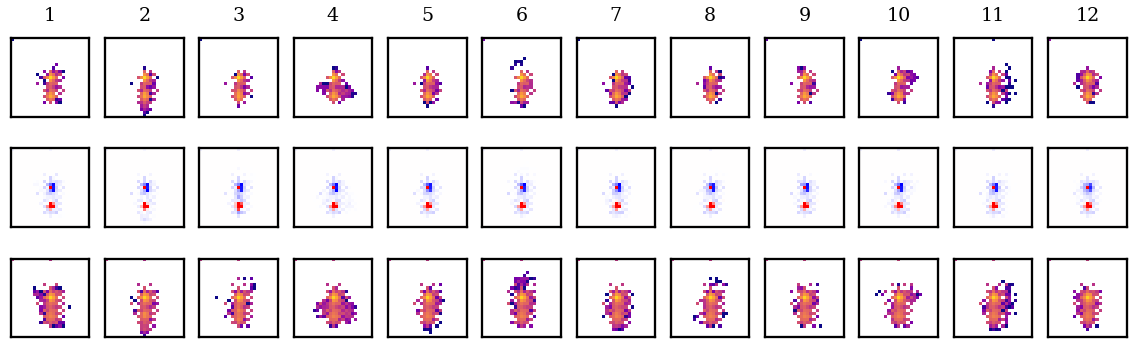

In [44]:
# plot the average of jet images generated from each latent space value

lme_QCD = plot_mean(lat_QCD)
lme_W = plot_mean(lat_W)
lme_pcc = lme_W - lme_QCD

fig, ax = plt.subplots(figsize=(20, 5.75))
for i in range(latent_size):
    ax = plt.subplot(3, latent_size, i+1)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.3) 
    plt.imshow(lme_W[i].reshape(25, 25), interpolation='nearest', norm=LogNorm(vmin=1e-3, vmax=300), cmap ='plasma')
    ax.set_title(str(i+1), y = 1.15, fontsize = 19)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, latent_size, i+1 + latent_size)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.3) 
    plt.imshow(lme_pcc[i].reshape(25, 25), interpolation ='nearest', cmap = "bwr", norm=Normalize(vmin=-5, vmax=+5))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, latent_size, i+1 + 2*latent_size)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.3) 
    plt.imshow(lme_QCD[i].reshape(25, 25), interpolation='nearest', norm=LogNorm(vmin=1e-3, vmax=300), cmap ='plasma')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

fig.savefig("Latent Space Average Jet Images with PCC.pdf", bbox_inches='tight')

In [45]:
# this is the LAGAN generator in https://github.com/hep-lbdl/adversarial-jets
# this is used to compare with the VAE

from keras.layers import Multiply
import keras.backend as K
from keras.layers import (Input, Dense, Reshape, Flatten, Lambda, merge,
                          Dropout, BatchNormalization, Activation, Embedding)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import (UpSampling2D, Conv2D, ZeroPadding2D,
                                        AveragePooling2D)
from keras.layers.local import LocallyConnected2D

from keras.models import Model, Sequential
def generator(latent_size, return_intermediate=False):

    loc = Sequential([
        Dense(128 * 7 * 7, input_dim=latent_size),
        Reshape((7, 7, 128)),

        Conv2D(64, (5, 5), padding='same', kernel_initializer ='he_uniform'),
        LeakyReLU(),
        BatchNormalization(),
        UpSampling2D(size=(2, 2)),

        ZeroPadding2D((2, 2)),
        LocallyConnected2D(6, (5, 5), kernel_initializer='he_uniform'),
        LeakyReLU(),
        BatchNormalization(),
        UpSampling2D(size=(2, 2)),

        LocallyConnected2D(6, (3, 3), kernel_initializer='he_uniform'),
        LeakyReLU(),
        LocallyConnected2D(1, (2, 2), use_bias=False, kernel_initializer='glorot_normal'),
        Activation('relu')
    ])

    latent = Input(shape=(latent_size, ))

    image_class = Input(shape=(1, ), dtype='int32')
    emb = Flatten()(Embedding(2, latent_size, input_length=1, embeddings_initializer ='glorot_normal')(image_class))

    h = Multiply()([latent, emb])

    fake_image = loc(h)

    return Model(inputs =[latent, image_class], outputs =fake_image)
gan = generator(200)
gan.load_weights('../input/generator-weights/lagan-generator (1).hdf5')

In [46]:
# generate GAN images
noise = np.random.normal(0, 1, (n, 200))
sampled_labels = np.random.randint(0, 2, n)
start_time2 = time.time()
gan_img = gan.predict([noise, sampled_labels.reshape(-1, 1)], verbose=False, batch_size=64) * 100
gan_time = time.time() - start_time2

In [48]:
# load the classifier and predict class probabilities for GAN, Pythia, and VAE jet images
classifier = load_model('../input/classifier/DFC_CNN.h5')
cvae_predict = classifier.predict(vae_images[0:n].reshape(n,25,25,1))
pythia_predict = classifier.predict(JETS[0:n].reshape(n,25,25,1))
gan_predict = classifier.predict(gan_img.reshape(n,25,25,1))

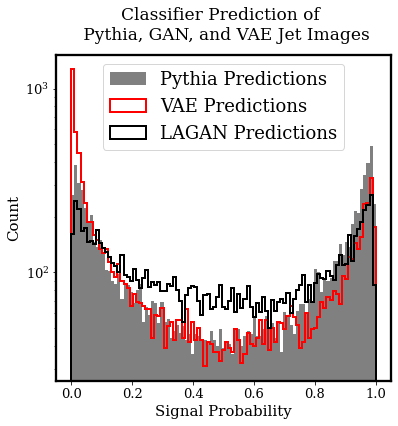

In [49]:
# plot classifier predictions
fig, ax = plt.subplots(figsize=(6, 6))
bins = np.linspace(0, 1, 100)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.hist(pythia_predict.ravel(), bins=bins, histtype='stepfilled', label=r"Pythia Predictions", color='gray', linewidth = 2)
plt.hist(cvae_predict.ravel(), bins=bins, histtype='step', label=r"VAE Predictions", color='red', linewidth = 2)
plt.hist(gan_predict.ravel(), bins=bins, histtype='step', label=r"LAGAN Predictions", color='black', linewidth = 2)

plt.xlabel(r'Signal Probability', fontsize=15, fontname= 'serif')
plt.ylabel(r'Count', fontsize=15, fontname= 'serif')
plt.yscale('log')

plt.xticks(fontsize=13, fontname= 'serif')
plt.yticks(fontsize=13, fontname= 'serif')
    
plt.title('Classifier Prediction of \n Pythia, GAN, and VAE Jet Images', fontsize = 17, fontname= 'serif', pad = 15)
plt.legend(fontsize = 18, loc = 'upper center')
fig.savefig("Classifier Predictions.pdf", bbox_inches='tight')

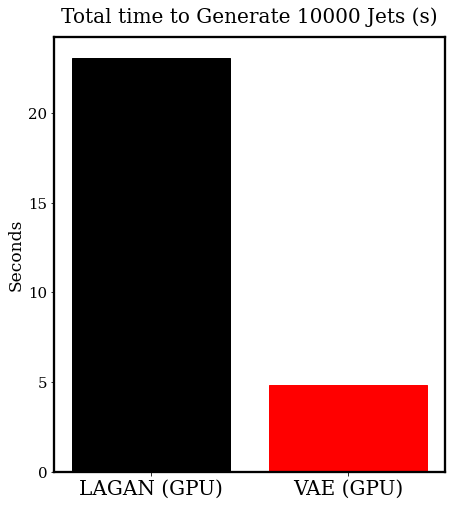

In [50]:
# plot total time it takes to generate 300,000 jet images for LAGAN and VAE
fig, ax = plt.subplots(figsize=(7, 8))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.3)
    
a = plt.bar(['LAGAN (GPU)', 'VAE (GPU)'],[gan_time, vae_time] , fill=True, linewidth = 1)
a[0].set_color('black')
a[1].set_color('red')

plt.ylabel('Seconds', fontsize = 17)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 15)
plt.title('Total time to Generate ' + str(n) + ' Jets (s)', fontsize = 20, y = 1.02)  
plt.show()

fig.savefig("Time Comparison of GAN and VAE " + 'GAN: ' + str(gan_time) + ', VAE: ' + str(vae_time) + '.pdf', bbox_inches='tight')

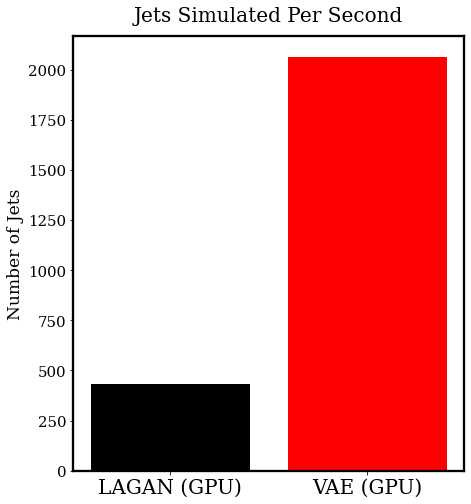

In [51]:
# plot rate (jets/s) for LAGAN and VAE
gan_rate = n / gan_time
vae_rate = n / vae_time

fig, ax = plt.subplots(figsize=(7, 8))
a = plt.bar(['LAGAN (GPU)', 'VAE (GPU)'],[gan_rate, vae_rate] , fill=True, linewidth = 1)
a[0].set_color('black')
a[1].set_color('red')

plt.ylabel('Number of Jets', fontsize = 17)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 15)
plt.title('Jets Simulated Per Second', fontsize = 20, y = 1.02)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.show()

fig.savefig("Rate Comparison of GAN and VAE " + 'GAN: ' + str(gan_rate) + ', VAE: ' + str(vae_rate) + '.pdf', bbox_inches='tight')

In [52]:
gan_img = gan_img.reshape(n,25,25)

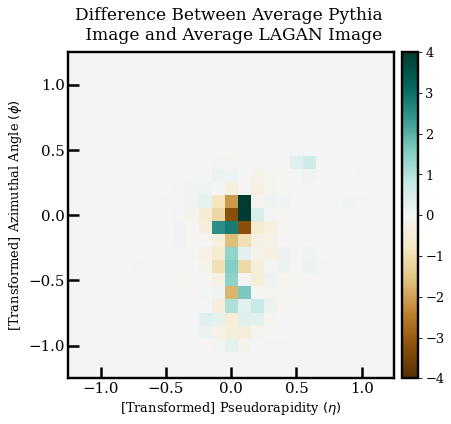

In [53]:
plot_diff_jet_image(gan_img.mean(axis=0)- JETS.mean(axis=0) ,"BrBG", 4, title='Difference Between Average Pythia \n Image and Average LAGAN Image',
                   save_title='Difference Between Average Pythia Image and Average LAGAN Image')

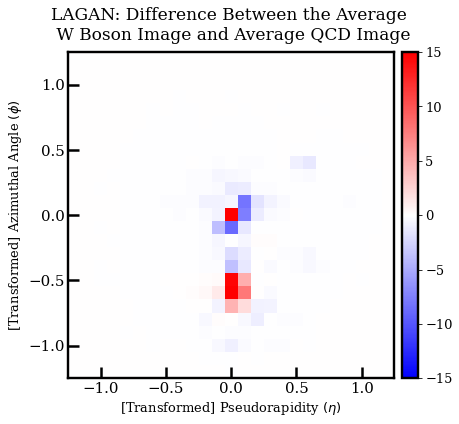

In [54]:
plot_diff_jet_image(gan_img[sampled_labels == 1].mean(axis=0) - gan_img[sampled_labels == 0].mean(axis=0) ,"bwr", 15, 
                    title='LAGAN: Difference Between the Average \n W Boson Image and Average QCD Image', 
                    save_title='LAGAN: Difference Between the Average W Boson Image and Average QCD Image')